In [1]:
import sys
sys.path.append('..')

In [2]:
# ckpt = '2501/COSEM_jrc-hela-UnetClassifier-l2/3/'
# ckpt = '2501/COSEM_jrc-hela-UnetClassifier-l2/6'
ckpt = '2502/Hagen-UnetClassifier-l2/3'
evaluate_test_data = True
# if normalize_channels is None, we use the setting (True/False) present in the trained model.
# if normalize_channels is True, then we normalize the channels in the dataset and xt_normalizer, defined below is dummy
# if normalize_channels is False, then we do not normalize the channels in the dataset and xt_normalizer, defined below normalizes the individual channels.
normalize_channels = False
assert normalize_channels in [None, True, False]
training_rootdir = '/group/jug/ashesh/training/diffsplit/'

In [3]:
import yaml
import os
import glob
import torch

def model_checkpoint_fpath(ckpt, fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(ckpt, fname=None):
    fpath = model_checkpoint_fpath(ckpt, fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train"]
    return {k: opt[k]['value'] for k in keys}

In [4]:
from model.ddpm_modules.time_predictor import TimePredictor
from time_prediction_training import get_datasets
import os

classifier_ckpt = os.path.join(training_rootdir, ckpt)

opt = load_config(classifier_ckpt)
# loading dataset.
if evaluate_test_data:
    if opt['datasets']['train']['name'] == 'Hagen':
        opt['datasets']['val']['datapath'] = {
        'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
        'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
        }
    elif opt['datasets']['train']['name'] == 'COSEM_jrc-hela':
        opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('/val', '/test')
    elif opt['datasets']['train']['name'] == 'HT_LIF24':
        opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('/val', '/test')
    else:
        raise NotImplementedError(f'{opt["datasets"]["train"]["name"]} not implemented')

if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

if normalize_channels is not None:
    print(f'Overriding normalize_channels with {normalize_channels}')
    opt['datasets']['normalize_channels'] = normalize_channels

Overriding normalize_channels with False


In [5]:
model_opt = opt['model']
model = TimePredictor(
    in_channel=model_opt['unet']['in_channel'],
    out_channel=model_opt['unet']['out_channel'],
    norm_groups=model_opt['unet']['norm_groups'],
    inner_channel=model_opt['unet']['inner_channel'],
    channel_mults=model_opt['unet']['channel_multiplier'],
    attn_res=model_opt['unet']['attn_res'],
    res_blocks=model_opt['unet']['res_blocks'],
    dropout=model_opt['unet']['dropout'],
    image_size=opt['datasets']['patch_size'],
    )
model = model.cuda()
model.load_state_dict(torch.load(os.path.join(classifier_ckpt,'best_time_predictor.pth')), strict=True)

# data
train_set, val_set = get_datasets(opt, tiled_pred=False)


TimePredictor
HARDCODED upperclip to 1993. Disable it if not needed !!!
Computing mean and std for normalization
[TimePredictorDataset] Data: 80x2x(2048, 2048) Patch:512 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:False ChW:[1.0, 1.0]
Adding Gaussian noise with std factor:  0.05
HARDCODED upperclip to 1993. Disable it if not needed !!!
[TimePredictorDataset] Data: 10x2x(2048, 2048) Patch:512 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False ChW:[1.0, 1.0]


100%|██████████| 200/200 [00:41<00:00,  4.87it/s]


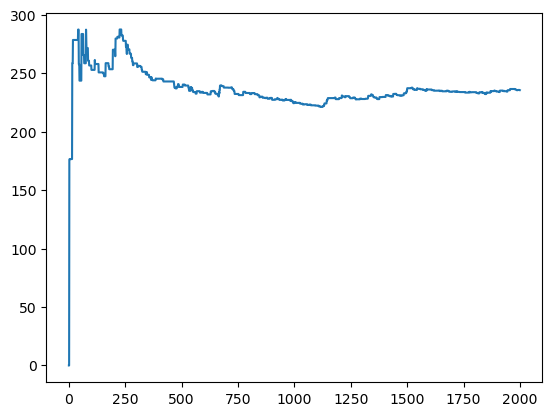

In [19]:
from model.normalizer import NormalizerXT
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt

normalizer_count = None
xt_normalizer = NormalizerXT()
if 'normalize_channels' in opt['datasets'] and opt['datasets']['normalize_channels'] is True:
    pass
else:
    val_set.reset_fixed_t()
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0)
    data_mean_arr = []
    data_std_arr = []
    normalizer_count = 200
    for _ in tqdm(range(normalizer_count)):
        bar = enumerate(val_loader)
        for i, (x, t_float) in bar:
            x = x.cuda()
            t_float = t_float.cuda()
            x = xt_normalizer.normalize(x,t_float, update=True)
            data_mean_arr.append(xt_normalizer.data_mean.cpu().numpy())
            data_std_arr.append(xt_normalizer.data_std.cpu().numpy())

    plt.plot(np.stack(data_mean_arr)[:,50])

In [20]:
from tqdm import tqdm
import numpy as np

num_timesteps = 10
gt = np.arange(0,1.0,1/num_timesteps)
pred_arr = []
inp_arr = []

with torch.no_grad():
    for mixing_t in tqdm(gt):
        val_set.set_fixed_t(mixing_t)
        dloader = torch.utils.data.DataLoader(
                    val_set,
                    batch_size=16,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True)
        for data in dloader:
            inp, t_float = data
            assert torch.std(t_float) < 1e-6, f'{t_float}'
            assert t_float[0] == mixing_t, f'{t_float} != {mixing_t}'
            inp = inp.cuda()
            t_float = t_float.cuda()
            # if xt_normalizer is dummy then nothing will happen with the following operation.
            inp = xt_normalizer.normalize(inp, t_float)
            inp_arr.append(inp.cpu().numpy())
            with torch.no_grad():
                pred = model(inp.cuda())
                pred_arr.append(pred.cpu().numpy())
    all_pred = np.concatenate(pred_arr).reshape(len(gt),-1)
    inp_arr = np.concatenate(inp_arr,axis=0)


100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


In [21]:
all_pred = np.concatenate(pred_arr).reshape(len(gt),-1)
inp_arr = np.concatenate(inp_arr,axis=0)


/tmp/ipykernel_18059/2798052624.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(gt,gt, 'k--', color='black')


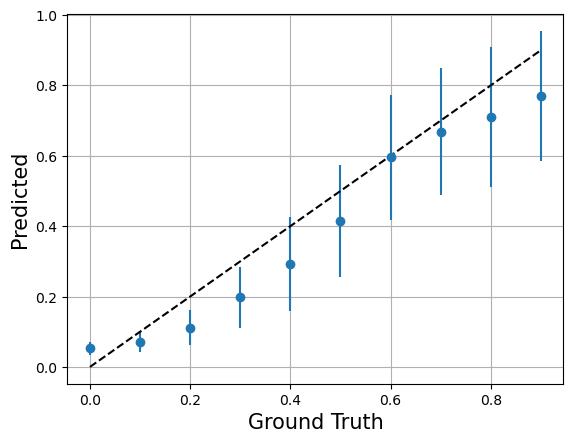

In [22]:
import matplotlib.pyplot as plt

err = all_pred.std(axis=1)
avg_pred = all_pred.mean(axis=1)
_,ax  = plt.subplots()
# plot with error bars
ax.errorbar(gt, avg_pred, yerr=err, fmt='o')
ax.plot(gt,gt, 'k--', color='black')
ax.set_xlabel('Ground Truth', fontsize=15)
ax.set_ylabel('Predicted', fontsize=15)
ax.grid()

In [23]:
mse = ((all_pred - gt.reshape(-1,1))**2).mean(axis=1)
dataset_str = opt['datasets']['train']['name']
dataset_str += ' Test' if evaluate_test_data else ' Val'
print(f'{dataset_str} NormCount:{normalizer_count} RMSE: {np.sqrt(mse.mean())}')

Hagen Test NormCount:200 RMSE: 0.16067392536862135


In [11]:
mse_mean = ((np.mean(all_pred, axis=1) - gt)**2).mean()
mse_median = ((np.median(all_pred, axis=1) - gt)**2).mean()
print(f'{dataset_str} NormCount:{normalizer_count} RMSE wrt Aggregated (mean) prediction: {np.sqrt(mse_mean)}')
print(f'{dataset_str} NormCount:{normalizer_count} RMSE wrt Aggregated (median) prediction: {np.sqrt(mse_median)}')

Hagen Test NormCount:8 RMSE wrt Aggregated (mean) prediction: 0.08926274867033439
Hagen Test NormCount:8 RMSE wrt Aggregated (median) prediction: 0.08562158756934801


In [12]:
len(train_set._data_dict[0])

80

In [13]:
# Test dataset

# 1 RMSE: 0.18584609868369045
# 10 COSEM_jrc-hela Test NormCount:10 RMSE: 0.11467985740375906
# 20 COSEM_jrc-hela Test NormCount:20 RMSE: 0.10733180019946625
# COSEM_jrc-hela Test NormCount:50 RMSE: 0.10229460707714132


In [14]:
# COSEM_jrc-hela Test NormCount:50 RMSE: 0.10632874237278825
# COSEM_jrc-hela Test NormCount:20 RMSE: 0.11445337831205459
# COSEM_jrc-hela Test NormCount:10 RMSE: 0.11869922239826158
# COSEM_jrc-hela Test NormCount:1 RMSE: 0.18200486158911253



In [15]:
# RMSE
# RMSE 0.12 (15 times training dataloader was used to generate the patch statistics)
# RMSE 0.164 (1 times training dataloader was used to generate the patch statistics)